### Potential training
An example notebook which shows how to train high-dimensional neural network potential (HDNNP). 

In [1]:
!gpustat

sasdsnode01.vito.local    Mon Mar 13 09:57:20 2023  510.108.03
[0] NVIDIA A100-PCIE-40GB | 35'C,   0 % |   605 / 40960 MB |


In [2]:
from utils import set_env
set_env('.env')

In [3]:
import os
os.environ["JAX_ENABLE_X64"] = "1"
# os.environ["JAX_PLATFORM_NAME"] = "cpu" 
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 

### Imports

In [4]:
import logging
import numpy as np
from pathlib import Path
import matplotlib.pylab as plt
import seaborn as sns
import random
from tqdm import tqdm
from collections import defaultdict
import jax.numpy as jnp
import jax

import jaxip
# from jaxip import logger
from jaxip.types import dtype as default_dtype
from jaxip.datasets import RunnerStructureDataset
from jaxip.potentials import NeuralNetworkPotential
from jaxip.logger import LoggingContextManager

In [5]:
# print(jaxip.__doc__)
# print(f"version: {jaxip.__version__}")

jaxip.logger.set_logging_level(logging.INFO)

default_dtype.FLOATX = jnp.float64
print(f"default dtype: {default_dtype.FLOATX.dtype}")

default dtype: float64


## Dataset

In [6]:
base_dir = Path('./GRN')

In [7]:
structures = RunnerStructureDataset(Path(base_dir, "input.data"), persist=True) 
# structures = RunnerStructureDataset(Path(base_dir, "input.data"), transform=ToStructure(r_cutoff=3.0), persist=True) 
print("Total number of structures:", len(structures))
structures

Total number of structures: 801


RunnerStructureDataset(filename='GRN/input.data', transform=ToStructure())

In [29]:
# indices = random.choices(range(len(structures)), k=100)
structures = [structures[i] for i in range(len(structures))] # len(structures) 

In [9]:
# energies = jnp.asarray([x.total_energy for x in structures]).reshape(-1)
# print("Energy difference:", max(energies) - min(energies))
# sns.histplot(energies);

In [10]:
s = structures[0]
s

Structure(natoms=24, elements=('C',), dtype=float64)

In [11]:
# with LoggingContextManager(level=logging.DEBUG):
# structures[0].to_dict()

In [12]:
# from ase.visualize import view
# atoms = s.to_ase_atoms()
# atoms
# view(atoms, viewer="x3d", repeat=2)

In [13]:
# from ase.io import read, write
# write("atoms.png", atoms * (2, 2, 1), rotation='30z,-80x')
# write("atoms.xyz", atoms * (2, 2, 1))
# ![atoms](atoms.png)

In [14]:
# from jaxip.structure import Structure
# sp = Structure.create_from_ase(atoms)
# view(sp.to_ase_atoms(), viewer="x3d", repeat=3)

## Potential

In [15]:
nnp = NeuralNetworkPotential.create_from(Path(base_dir, "input.nn"))
nnp

INFO Number of elements: 1
INFO Element: C (6)
INFO Updater type: 'kalman_filter'


NeuralNetworkPotential(atomic_potential={'C': AtomicPotential(
  descriptor=ACSF(element='C', num_symmetry_functions=30, r_cutoff=12.0),
  scaler=DescriptorScaler(scale_type='center', scale_min=0.0, scale_max=1.0),
  model=NeuralNetworkModel(hidden_layers=((15, 'tanh'), (15, 'tanh')), output_layer=(1, 'identity')),
)})

In [16]:
# from jaxip.potentials import NeuralNetworkPotential
# from jaxip.potentials import NeuralNetworkPotentialSettings as Settings
    
# settings = Settings(**nnp.settings.dict())
# nnp2 = NeuralNetworkPotential(settings)    
    
# nnp.settings.to_json('h2o.json')
# settings = Settings.from_json('h2o.json')
# nnp2 = NeuralNetworkPotential(settings)

# nnp2

In [17]:
# nnp.load()

##### Extrapolation warnings

In [18]:
# nnp.set_extrapolation_warnings(100)

##### Fit scaler

In [19]:
nnp.fit_scaler(structures)

Fitting descriptor scaler...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 801/801 [00:37<00:00, 21.27it/s]

Done.


In [20]:
time nnp(s)

CPU times: user 5.07 s, sys: 166 ms, total: 5.23 s
Wall time: 2.97 s


Array(2.43127347, dtype=float64)

In [21]:
time force = nnp.compute_force(s)

CPU times: user 36 s, sys: 413 ms, total: 36.4 s
Wall time: 24.6 s


### Training

In [ ]:
h = nnp.fit_model(structures)

for sub in h:
    if 'loss' in sub:
        plt.plot(h['epoch'], h[sub], label=sub)
plt.legend();

In [31]:
nnp.save()

INFO Saving scaler parameters for element (C): scaling.006.data
INFO Saving model weights for element (C): weights.006.pkl


### Validation

##### Energy

len(structures)=801


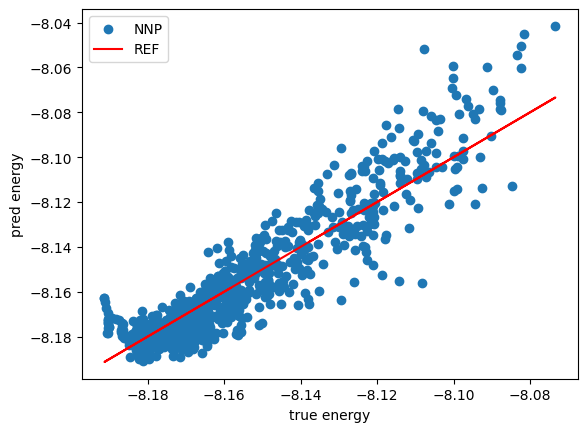

In [32]:
print(f"{len(structures)=}")
true_energy = [s.total_energy for s in structures]
pred_energy = [nnp(s) for s in structures]
ii = range(len(structures))
plt.scatter(true_energy, pred_energy, label='NNP')
plt.plot(true_energy, true_energy, 'r', label="REF")
plt.xlabel("true energy")
plt.ylabel("pred energy")
plt.legend()
plt.show()

##### Force

len(structures)=801


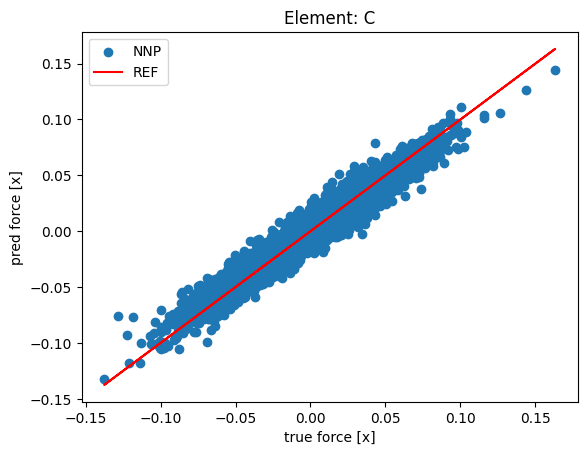

In [33]:
import jax.numpy as jnp

true_forces = defaultdict(list)
pred_forces = defaultdict(list)

print(f"{len(structures)=}")
for structure in structures:
    true_forces_per_structure = structure.get_forces()
    pred_forces_per_structure = nnp.compute_force(structure)

    for element in nnp.elements:
        true_forces[element].append(true_forces_per_structure[element])
        pred_forces[element].append(pred_forces_per_structure[element])

dim = 0
to_axis = {d: c for d, c in enumerate('xyz')}
for element in nnp.elements:
    true_forces[element] = jnp.concatenate(true_forces[element], axis=0)
    pred_forces[element] = jnp.concatenate(pred_forces[element], axis=0)

    plt.scatter(true_forces[element][:, dim], pred_forces[element][:, dim], label='NNP')
    plt.plot(true_forces[element][:, dim], true_forces[element][:, dim], 'r', label='REF')
    plt.title(f"Element: {element}")
   
    label= f"force [{to_axis[dim]}]"
    plt.ylabel("pred " + label)
    plt.xlabel("true " + label)
    plt.legend()
    plt.show()